## Imports

In [1]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt


from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [2]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
        un = u.copy() 
    for i in range(1, nx-1):
        u[i] = un[i] - un[i]*dt/dx*(un[i] - un[i-1]) + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    return 0

## Numba accelerator

In [3]:
#add the numba decorator to accelerate code
from numba import njit
@njit
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    #fill the update of u
    for n in range(nt):
        un = u.copy() 
    for i in range(1, nx-1):
        u[i] = un[i] - un[i]*dt/dx*(un[i] - un[i-1]) + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    
        
    return 0

## Pyccel accelerator

In [17]:
#add the pyccel decorator to accelerate code
@types('float[:]', 'float[:]', 'int', 'int', 'float','float', 'float')
def solve_1d_burger_pyccel(u , un , nt , nx , dt, dx , nu):
    for n in range(nt):
        un = u.copy() 
    for i in range(1, nx-1):
        u[i] = un[i] - un[i]*dt/dx*(un[i] - un[i-1]) + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
        
    return 0

## Inputs

In [10]:
#sympy computation
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [11]:
###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## Plot initial condition

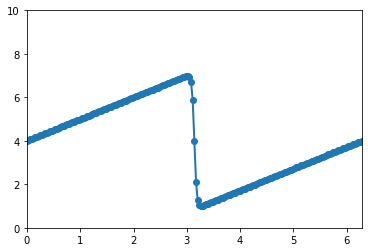

In [12]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

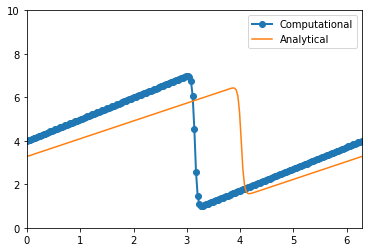

In [13]:
solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

## Call Funtions

### Pure function

In [14]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

295 µs ± 5.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Function with numba accelerator

In [15]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
26.9 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [16]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)


ERROR at annotation (semantic) stage
pyccel:
 |fatal [semantic]: mod_aie2jzh1ttmj_aie2jzh1ttmj.py [4,13]| Attribute copy not found



PyccelSemanticError: Semantic step failed